# Test different clustering methods to identify scenarios of high criticality
- PRIM
- K-means
- CART

## Get feature importance
- get dependence measures between features

In [2]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [4]:
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'

In [5]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

comb_scenarios = {}
with ThreadPoolExecutor(max_workers=6) as executor:
    for result in executor.map(read_ladris_from_db, queries):
        comb_scenarios.update(result)

print(len(comb_scenarios))

8998


### Create Dataframes from the database read
- df_results: a dataframe of the results
- df: a dataframe of the inputs

In [6]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [7]:
experiments = df
### Create outcomes as an array of df_results
outcomes = list(df_results[0].values)

In [8]:
print(len(experiments), len(outcomes))

8998 8998


In [9]:
### print descriptive statistics of outcomes
print(df_results.describe())
resultsDesc = df_results.describe()


                 0
count  8998.000000
mean      4.110287
std       1.742195
min       0.000000
25%       3.948825
50%       4.389533
75%       4.998629
max      10.857103


In [10]:
quantileDF = df_results[0].quantile([0.1, 0.15, 0.2, .25, 0.3, 0.35, 0.4, .45, .5, 0.55, .65, .75, 0.85, 0.95])
print(quantileDF)

### print quantile 0.65 of quantileDF
print(quantileDF[0.65])

0.10    0.000000
0.15    3.729948
0.20    3.834420
0.25    3.948825
0.30    4.099914
0.35    4.191592
0.40    4.244900
0.45    4.309894
0.50    4.389533
0.55    4.476327
0.65    4.715357
0.75    4.998629
0.85    5.397705
0.95    5.945152
Name: 0, dtype: float64
4.715356994444445


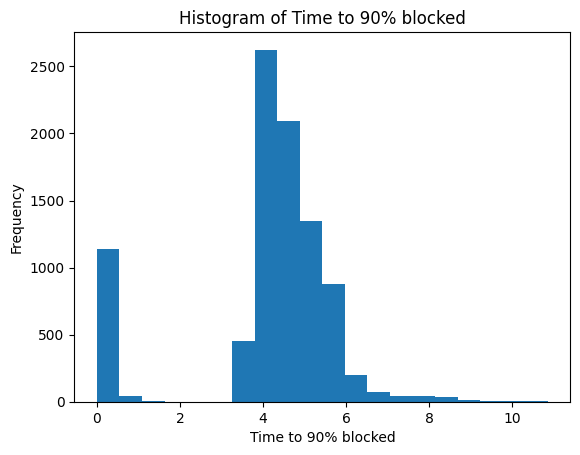

In [11]:
### Plot histogram of df_results[0]
df_results[0].plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')
plt.title('Histogram of Time to 90% blocked')
plt.show()



In [12]:
### resultsDesc print the value for 0 at row index '50%'
print(resultsDesc.loc['50%'][0])
print(quantileDF[0.5])


4.3895335
4.3895335


In [13]:
print(len(experiments[df_results[0] > quantileDF[0.5]]))
print(len(df_results[df_results[0] > quantileDF[0.5]]))
print(len(df_results))

4499
4499
8998


In [14]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > quantileDF[0.5]]
low_results = df_results[df_results[0] <= quantileDF[0.5]]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > quantileDF[0.5]]
low_inputs = experiments[df_results[0] <= quantileDF[0.5]]

### print the count of high and low outcomes
print(len(high_results))
print(len(low_results))

### print the count of high and low inputs
print(len(high_inputs))
print(len(low_inputs))


4499
4499
4499
4499


# Prim analysis

In [14]:
np_results = df_results[0].to_numpy()

In [15]:
np_results

array([4.18388344, 4.32193894, 4.79188019, ..., 3.79080972, 3.70907107,
       0.        ])

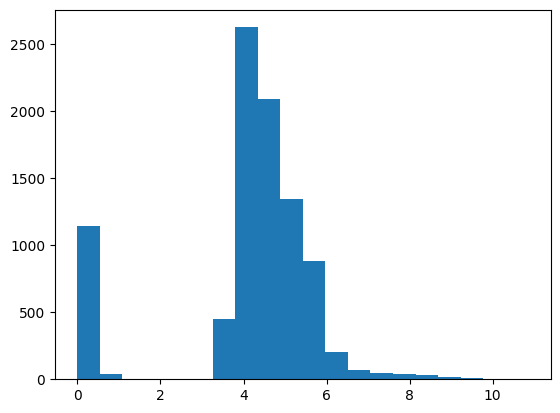

In [16]:
### plot df_results
import matplotlib.pyplot as plt

### plot histogram of df_results
plt.hist(df_results[0], bins=20)
plt.show()

In [17]:
import prim as p_rim

In [18]:
result_limits = {}

# High and Low Limits Data

In [15]:
### establish data sets for high and low outcomes
high_results = df_results[df_results[0] > quantileDF[0.5]]
low_results = df_results[df_results[0] <= quantileDF[0.5]]

### establish data sets for high and low inputs
high_inputs = experiments[df_results[0] > quantileDF[0.5]]
low_inputs = experiments[df_results[0] <= quantileDF[0.5]]

### print the count of high and low outcomes
print(len(high_results))
print(len(low_results))

### print the count of high and low inputs
print(len(high_inputs))
print(len(low_inputs))

4499
4499
4499
4499


In [16]:
### Print the length of high and low results and high and low inputs
print(len(high_results))
print(len(low_results))
print(len(high_inputs))
print(len(low_inputs))

4499
4499
4499
4499


# PRIM Analysis

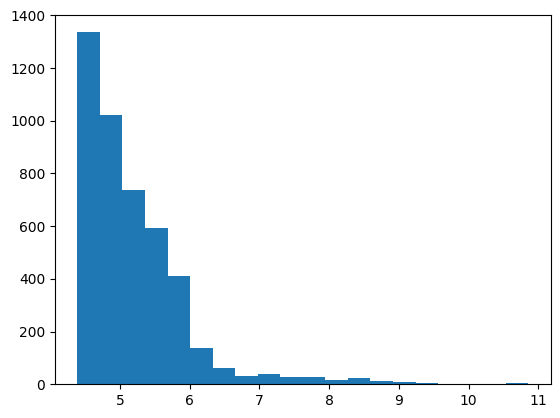

In [21]:
### show histogram of high results
plt.hist(high_results[0], bins=20)
plt.show()


In [17]:
### select random 1000 samples of high and low results
import random

### get 1000 indexes of high and low results
#high_indexes = random.sample(range(0, len(high_results)), 1000)
#low_indexes = random.sample(range(0, len(low_results)), 1000)

samp_high_results = []
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))
samp_high_results.append(random.sample(range(0, len(high_results)), 1000))

samp_low_results = []
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))
samp_low_results.append(random.sample(range(0, len(low_results)), 1000))



In [23]:
### get the rows of high_inputs based on samp_high_results[0]
high_inputs.iloc[samp_high_results[0]]

,333615,332041,343220,328559,329741,329385,334269,332584,344418,331224,...,330399,331209,328168,335242,344419,341317,335083,341540,332615,332386
2469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1591,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4989,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2638,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5807,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6247,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1943,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
quantileDF[0.75]

4.998628680555555

In [25]:
prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=quantileDF[0.75], threshold_type='>')
box = prim_alg.find_box()
print(len(box.limits))

10


In [26]:
result_limits['high_limits'] = box.limits

In [27]:
prim_alg = p_rim.Prim(low_inputs, low_results[0], threshold=resultsDesc.loc['25%'][0], threshold_type='<')
box = prim_alg.find_box()
print(len(box.limits))

13


In [28]:
result_limits['low_limits'] = box.limits

In [29]:
### run prim on all samp_high_results
for i in range(len(samp_high_results)):
    prim_alg = p_rim.Prim(high_inputs.iloc[samp_high_results[i]], high_results.iloc[samp_high_results[i]][0], threshold=quantileDF[0.55], threshold_type=">")
    box = prim_alg.find_box()
    print(len(box.limits))
    result_limits['samp_high_results_' + str(i)] = box.limits
          

#prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=22000.0, threshold_type=">")
print(result_limits.keys())

35
36
44
30
dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3'])


In [31]:
result_limits['samp_high_results_3']

,min,max,qp values
339837,0.0,0.0,0.000540
341444,0.0,0.0,0.003056
341075,0.0,0.0,0.007590
332388,0.0,0.0,0.051553
343278,0.0,0.0,0.054030
335096,0.0,0.0,0.054308
341348,0.0,0.0,0.055702
332208,0.0,0.0,0.057673
331203,0.0,0.0,0.136803
332163,0.0,0.0,0.137293


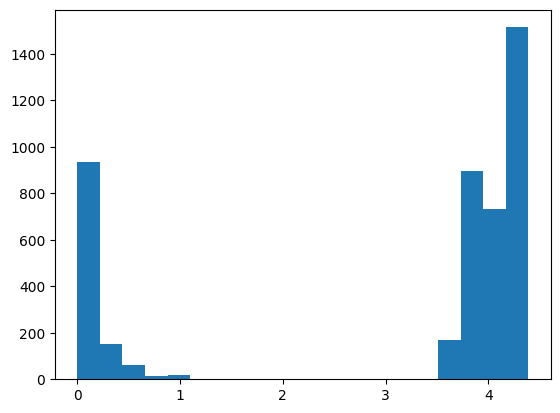

In [32]:
### plot histogram of low results
plt.hist(low_results[0], bins=20)
plt.show()

In [33]:
quantileDF[0.45]

4.30989376388889

In [34]:
### run prim on all samp_low_results
for i in range(len(samp_low_results)):
    prim_alg = p_rim.Prim(low_inputs.iloc[samp_low_results[i]], low_results.iloc[samp_low_results[i]][0], threshold=quantileDF[0.45], threshold_type="<")
    box = prim_alg.find_box()
    print(len(box.limits))
    result_limits['samp_low_results_' + str(i)] = box.limits
          

#prim_alg = p_rim.Prim(high_inputs, high_results[0], threshold=22000.0, threshold_type=">")
print(result_limits.keys())

35
35
35
33
dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3'])


In [36]:
### drop key values 'samp_low_limits 0', 'samp_low_limits)0', 'samp_low_limits_0' from result_limits
print(len(result_limits.keys()))
result_limits.keys()



10


dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3'])

In [37]:
result_limits['samp_low_results_1']

,min,max,qp values
333610,0.0,0.0,0.008124
343320,0.0,0.0,0.014737
336365,0.0,0.0,0.035645
335452,0.0,0.0,0.035969
329557,0.0,0.0,0.036953
329103,0.0,0.0,0.067583
334127,0.0,0.0,0.073415
328750,0.0,0.0,0.129797
328800,0.0,0.0,0.130594
333567,0.0,0.0,0.140262


# KMeans tests of the inputs finding input paterns

In [38]:
### cluster the results
from sklearn.cluster import KMeans

### kmeans cluster the columns of high_inputs
kmeans = KMeans(n_clusters=4, random_state=21).fit(high_inputs.T)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())


0    2271
3      22
1       1
2       1
Name: count, dtype: int64


In [39]:
### print the labels for cluster 2
print(high_inputs.columns[kmeans.labels_ == 2])


Index([335452], dtype='int64')


In [40]:
result_limits['high_kmeans'] = kmeans

In [41]:
### kmeans cluster the columns of high_inputs
kmeans = KMeans(n_clusters=4, random_state=21).fit(low_inputs.T)

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())

2    2292
0       1
3       1
1       1
Name: count, dtype: int64


In [42]:
result_limits['low_kmeans'] = kmeans

In [43]:
result_limits['low_kmeans']

KMeans(n_clusters=4, random_state=21)

In [44]:
### get the index's of results for each cluster
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

idx0 = []
idx1 = []
idx2 = []
idx3 = []

for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        cluster0.append(df_resultsMAX[0].iloc[i])
        idx0.append(i)
    elif kmeans.labels_[i] == 1:
        cluster1.append(df_resultsMAX[0].iloc[i])
        idx1.append(i)
    elif kmeans.labels_[i] == 2:
        cluster2.append(df_resultsMAX[0].iloc[i])
        idx2.append(i)
    elif kmeans.labels_[i] == 3:
        cluster3.append(df_resultsMAX[0].iloc[i])
        idx3.append(i)

len(cluster0)

NameError: name 'df_resultsMAX' is not defined

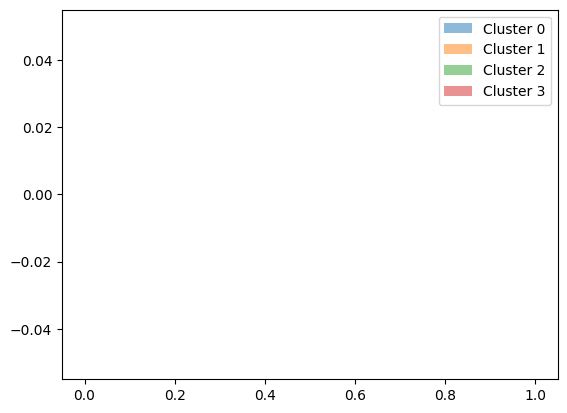

In [45]:
### plot a histogram all the clusters
plt.hist(cluster0, bins=10, alpha=0.5, label='Cluster 0')
plt.hist(cluster1, bins=10, alpha=0.5, label='Cluster 1')
plt.hist(cluster2, bins=10, alpha=0.5, label='Cluster 2')
plt.hist(cluster3, bins=10, alpha=0.5, label='Cluster 3')
plt.legend(loc='upper right')
plt.show()

In [46]:
### print colum names of df.iloc[idx0] that have values greater than 0
print(len(df.iloc[idx0].columns[(df.iloc[idx0] > 0).any()]))
print(len(df.iloc[idx1].columns[(df.iloc[idx1] > 0).any()]))
print(len(df.iloc[idx2].columns[(df.iloc[idx2] > 0).any()]))
print(len(df.iloc[idx3].columns[(df.iloc[idx3] > 0).any()]))



0
0
0
0


In [47]:
### for each df.iloc[idx0] print the sum of all columns sorted from highest to lowest
print(df.iloc[idx0].sum().sort_values(ascending=False))

### get the top 10 columns of df.iloc[idx0] that have the highest sum
maxSegs0 = df.iloc[idx0].sum().sort_values(ascending=False).head(200)
maxSegs1 = df.iloc[idx1].sum().sort_values(ascending=False).head(200)
maxSegs2 = df.iloc[idx2].sum().sort_values(ascending=False).head(200)
maxSegs3 = df.iloc[idx3].sum().sort_values(ascending=False).head(200)


333615    0.0
341080    0.0
337579    0.0
341139    0.0
344028    0.0
         ... 
334900    0.0
334727    0.0
334009    0.0
329259    0.0
332386    0.0
Length: 2295, dtype: float64


In [48]:
overlaps = []
### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx1]
overlap = maxSegs0.index.intersection(maxSegs1.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx2]
overlap = maxSegs0.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx0] and df.iloc[idx3]
overlap = maxSegs0.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx2]
overlap = maxSegs1.index.intersection(maxSegs2.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx1] and df.iloc[idx3]
overlap = maxSegs1.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)

### measure the overlap of the top 10 columns of df.iloc[idx2] and df.iloc[idx3]
overlap = maxSegs2.index.intersection(maxSegs3.index)
overlaps.append(overlap)
print(overlap)


Index([333615, 341080, 337579, 341139, 344028, 332438, 333773, 343270, 330169,
       335037,
       ...
       329669, 334942, 339713, 330510, 331469, 334343, 335199, 334362, 331075,
       342001],
      dtype='int64', length=200)
Index([333615, 341080, 337579, 341139, 344028, 332438, 333773, 343270, 330169,
       335037,
       ...
       329669, 334942, 339713, 330510, 331469, 334343, 335199, 334362, 331075,
       342001],
      dtype='int64', length=200)
Index([333615, 341080, 337579, 341139, 344028, 332438, 333773, 343270, 330169,
       335037,
       ...
       329669, 334942, 339713, 330510, 331469, 334343, 335199, 334362, 331075,
       342001],
      dtype='int64', length=200)
Index([333615, 341080, 337579, 341139, 344028, 332438, 333773, 343270, 330169,
       335037,
       ...
       329669, 334942, 339713, 330510, 331469, 334343, 335199, 334362, 331075,
       342001],
      dtype='int64', length=200)
Index([333615, 341080, 337579, 341139, 344028, 332438, 333773, 34327

In [65]:
for o in overlaps:
    for i in o:
        if i in primSegments:
            print(i)

NameError: name 'primSegments' is not defined

Text(0, 0.5, 'Frequency')

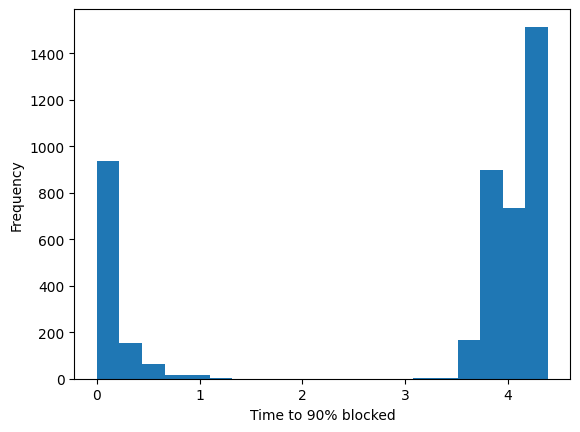

In [49]:
low_results[0].plot(kind='hist', bins=20)
plt.xlabel('Time to 90% blocked')
plt.ylabel('Frequency')

# CART Tests
- low coverage values indicate boxes of rare specific behaviors
- high coverage values indicate boxes of general themes
- res dim indicates the number of features associated with the variation

In [50]:
#low_results[0]

### create a numpy array of df_results less than 3.99
np_results = low_results[0].to_numpy()
### modify np_results to be an array of true or false values 
np_results = np_results < resultsDesc.loc['25%'][0]
### print the length of np_results
print(len(np_results), len(low_inputs))

4499 4499


In [51]:
### perform CART on the high inputs and high results
import ema_workbench.analysis.cart as CART

ca = CART.CART(low_inputs, np_results)
ca.build_tree()

In [52]:
print(ca.boxes_to_dataframe())

       box 1      box 2      box 3      box 4      box 5      box 6     
         min  max   min  max   min  max   min  max   min  max   min  max
331892   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0
344278   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0
328743   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0
336214   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0
343215   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0


In [53]:
boxesdf = ca.boxes_to_dataframe()

In [54]:
len(ca.boxes)

6

In [55]:
for i in range(1, len(ca.boxes)):
    print(len(boxesdf['box {}'.format(i)]))

5
5
5
5
5


In [56]:
result_limits['low_CART'] = ca

In [57]:
low_results.iloc[samp_low_results[0]][0].to_numpy() < resultsDesc.loc['25%'][0]

array([False,  True,  True, False, False,  True,  True, False, False,
       False, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False,  True, False,  True, False,
       False,  True, False, False,  True, False,  True, False,  True,
       False, False, False,  True, False,  True, False,  True,  True,
       False,  True,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True, False, False,  True,  True,  True, False, False,  True,
       False, False, False, False,  True,  True,  True,  True, False,
        True,  True, False, False,  True, False, False,  True,  True,
        True,  True,

In [1]:
samp_low_results.shape

NameError: name 'samp_low_results' is not defined

In [58]:
### Run CART on samp_low_results
for i in range(len(samp_low_results)):
    slr = low_results.iloc[samp_low_results[i]][0].to_numpy() < resultsDesc.loc['25%'][0]
    ca = CART.CART(low_inputs.iloc[samp_low_results[i]], slr)
    ca.build_tree()
    print(ca.stats_to_dataframe())
    print(ca.boxes_to_dataframe())
    result_limits['samp_low_CART_' + str(i)] = ca

       coverage   density  res dim   mass
box 1  0.602386  0.527875        8  0.574
box 2  0.065606  0.540984        8  0.061
box 3  0.059642  0.566038        7  0.053
box 4  0.065606  0.660000        6  0.050
box 5  0.071571  0.692308        5  0.052
box 6  0.039761  0.370370        4  0.054
box 7  0.033797  0.333333        3  0.051
box 8  0.029821  0.300000        2  0.050
box 9  0.031809  0.290909        1  0.055
       box 1      box 2      box 3      box 4      box 5      box 6       \
         min  max   min  max   min  max   min  max   min  max   min  max   
339713   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
334595   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   
336324   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   
336263   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
329098   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
335287   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0

In [59]:
slr = high_results[0].to_numpy() > resultsDesc.loc['75%'][0]
ca = CART.CART(high_inputs, slr)
ca.build_tree()


In [60]:
print(ca.stats_to_dataframe())

print(ca.boxes_to_dataframe())

boxesdf = ca.boxes_to_dataframe()
boxesdf.head()

       coverage   density  res dim      mass
box 1  0.503556  0.411252        7  0.612358
box 2  0.060889  0.600877        7  0.050678
box 3  0.061333  0.600000        6  0.051122
box 4  0.062667  0.610390        5  0.051345
box 5  0.068000  0.614458        4  0.055346
box 6  0.071111  0.620155        3  0.057346
box 7  0.082222  0.635739        2  0.064681
box 8  0.090222  0.789883        1  0.057124
       box 1      box 2      box 3      box 4      box 5      box 6       \
         min  max   min  max   min  max   min  max   min  max   min  max   
330610   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   
335412   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
339766   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
330631   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   
340982   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   
330620   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5  

box 1      box 2      box 3      box 4      box 5      box 6       \
         min  max   min  max   min  max   min  max   min  max   min  max   
330610   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   
335412   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
339766   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
330631   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   
340982   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   

       box 7      box 8       
         min  max   min  max  
330610   0.0  1.0   0.0  1.0  
335412   0.0  0.5   0.5  1.0  
339766   0.0  1.0   0.0  1.0  
330631   0.0  1.0   0.0  1.0  
340982   0.0  1.0   0.0  1.0

In [61]:
result_limits['high_CART'] = ca

In [62]:
### Run CART on samp_high_results
for i in range(len(samp_high_results)):
    slr = high_results.iloc[samp_high_results[i]][0].to_numpy() > resultsDesc.loc['75%'][0]
    ca = CART.CART(high_inputs.iloc[samp_high_results[i]], slr)
    ca.build_tree()
    print(ca.stats_to_dataframe())
    print(ca.boxes_to_dataframe())
    result_limits['samp_high_CART_' + str(i)] = ca

       coverage   density  res dim   mass
box 1  0.441237  0.392661        8  0.545
box 2  0.030928  0.294118        8  0.051
box 3  0.063918  0.553571        7  0.056
box 4  0.059794  0.580000        6  0.050
box 5  0.068041  0.568966        5  0.058
box 6  0.070103  0.618182        4  0.055
box 7  0.078351  0.666667        3  0.057
box 8  0.092784  0.681818        2  0.066
box 9  0.094845  0.741935        1  0.062
       box 1      box 2      box 3      box 4      box 5      box 6       \
         min  max   min  max   min  max   min  max   min  max   min  max   
334728   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
330221   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
330610   0.0  0.5   0.0  0.5   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   
335412   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0.5   
331030   0.0  0.5   0.5  1.0   0.0  1.0   0.0  1.0   0.0  1.0   0.0  1.0   
330617   0.0  0.5   0.0  0.5   0.0  0.5   0.0  0

In [63]:
print(len(result_limits))

22


In [64]:
result_limits.keys()

dict_keys(['high_limits', 'low_limits', 'samp_high_results_0', 'samp_high_results_1', 'samp_high_results_2', 'samp_high_results_3', 'samp_low_results_0', 'samp_low_results_1', 'samp_low_results_2', 'samp_low_results_3', 'high_kmeans', 'low_kmeans', 'low_CART', 'samp_low_CART_0', 'samp_low_CART_1', 'samp_low_CART_2', 'samp_low_CART_3', 'high_CART', 'samp_high_CART_0', 'samp_high_CART_1', 'samp_high_CART_2', 'samp_high_CART_3'])

In [65]:
### create function go get feature names from prim limits
def get_feature_names(limits):
    feature_names = []
    for key in list(limits.index):        
        ### convert key to integer        
        feature_names.append(int(key))
    return feature_names

def get_kmeans_features(df, kmeans, cluster):
    return df.columns[kmeans.labels_ == cluster]


In [66]:
### Get the features from PRIM
print(get_feature_names(result_limits['high_limits']))

### Get the features from the kmeans
print(list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 2]))

### get the feature names from the cart
print(get_feature_names(result_limits['high_CART'].boxes_to_dataframe()['box 2']))

### print the number of clusters in result_limits['high_kmeans']
print(len(pd.Series(result_limits['high_kmeans'].labels_).value_counts()))
### print the number of boxes in result_limits['high_CART']
print(len(result_limits['high_CART'].boxes_to_dataframe()))


[335412, 343224, 328162, 329204, 344403, 329173, 333734, 341405, 331203, 329129]
[335452]
[330610, 335412, 339766, 330631, 340982, 330620, 330615]
4
7


In [67]:
highClusters = {}
highClusters['prim'] = get_feature_names(result_limits['high_limits'])
highClusters['prim1'] = get_feature_names(result_limits['samp_high_results_0'])
highClusters['prim2'] = get_feature_names(result_limits['samp_high_results_1'])
highClusters['prim3'] = get_feature_names(result_limits['samp_high_results_2'])
highClusters['prim4'] = get_feature_names(result_limits['samp_high_results_3'])
highClusters['kmeans'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 0])
highClusters['kmeans1'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 1])
highClusters['kmeans2'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 2])
highClusters['kmeans3'] = list(high_inputs.columns[result_limits['high_kmeans'].labels_ == 3])
highClusters['cart'] = get_feature_names(result_limits['high_CART'].boxes_to_dataframe()['box 2'])
highClusters['cart1'] = get_feature_names(result_limits['samp_high_CART_0'].boxes_to_dataframe()['box 2'])
highClusters['cart2'] = get_feature_names(result_limits['samp_high_CART_1'].boxes_to_dataframe()['box 2'])
highClusters['cart3'] = get_feature_names(result_limits['samp_high_CART_2'].boxes_to_dataframe()['box 2'])
highClusters['cart4'] = get_feature_names(result_limits['samp_high_CART_3'].boxes_to_dataframe()['box 2'])


lowClusters = {}
lowClusters['prim'] = get_feature_names(result_limits['low_limits'])
lowClusters['prim1'] = get_feature_names(result_limits['samp_low_results_0'])
lowClusters['prim2'] = get_feature_names(result_limits['samp_low_results_1'])
lowClusters['prim3'] = get_feature_names(result_limits['samp_low_results_2'])
lowClusters['prim4'] = get_feature_names(result_limits['samp_low_results_3'])
lowClusters['kmeans'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 0])
lowClusters['kmeans1'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 1])
lowClusters['kmeans2'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 2])
lowClusters['kmeans3'] = list(low_inputs.columns[result_limits['low_kmeans'].labels_ == 3])
lowClusters['cart'] = get_feature_names(result_limits['low_CART'].boxes_to_dataframe()['box 2'])
lowClusters['cart1'] = get_feature_names(result_limits['samp_low_CART_0'].boxes_to_dataframe()['box 2'])
lowClusters['cart2'] = get_feature_names(result_limits['samp_low_CART_1'].boxes_to_dataframe()['box 2'])
lowClusters['cart3'] = get_feature_names(result_limits['samp_low_CART_2'].boxes_to_dataframe()['box 2'])
lowClusters['cart4'] = get_feature_names(result_limits['samp_low_CART_3'].boxes_to_dataframe()['box 2'])

In [68]:
highClusters['prim1']

[335018,
 346470,
 329918,
 334046,
 340885,
 328162,
 329475,
 333858,
 328367,
 340633,
 338980,
 329741,
 328863,
 341474,
 343011,
 334794,
 332423,
 340985,
 341290,
 343798,
 335091,
 334230,
 331343,
 341327,
 335967,
 331731,
 334994,
 344338,
 343065,
 340593,
 336010,
 335082,
 330114,
 330116,
 335467]

In [69]:
highClusters['cart']

[330610, 335412, 339766, 330631, 340982, 330620, 330615]

### Find similar features from the 3 clusters

In [70]:
### for each highClusters find the intersection of the features
hc_count = {}
for hc in highClusters.keys():
    print(hc)
    for hc2 in highClusters.keys():
        if hc != hc2:            
            print("\t",hc2)
            intersect = set(highClusters[hc]).intersection(set(highClusters[hc2]))
            print("\t", intersect)
            for i in intersect:
                if i in hc_count.keys():
                    hc_count[i] += 1
                else:
                    hc_count[i] = 1
                  
print(" ------------------------------------ ")

lc_count = {}
### for each lowClusters find the intersection of the features
for lc in lowClusters.keys():
    print(lc)
    for lc2 in lowClusters.keys():
        if lc != lc2:            
            print("\t", lc2)
            intersect = set(lowClusters[lc]).intersection(set(lowClusters[lc2]))
            print("\t", intersect)
            for i in intersect:
                if i in lc_count.keys():
                    lc_count[i] += 1
                else:
                    lc_count[i] = 1


prim
	 prim1
	 {328162}
	 prim2
	 {331203}
	 prim3
	 {328162, 341405}
	 prim4
	 {331203, 329173}
	 kmeans
	 {328162, 331203, 333734, 329129, 344403, 335412, 329204, 329173, 343224, 341405}
	 kmeans1
	 set()
	 kmeans2
	 set()
	 kmeans3
	 set()
	 cart
	 {335412}
	 cart1
	 {335412}
	 cart2
	 {335412}
	 cart3
	 {335412}
	 cart4
	 {335412}
prim1
	 prim
	 {328162}
	 prim2
	 {334994, 335467, 332423}
	 prim3
	 {328162, 334994, 335091, 343065, 335967}
	 prim4
	 {334994, 335467, 341327}
	 kmeans
	 {330114, 329475, 330116, 332423, 336010, 329741, 334994, 344338, 340885, 334230, 340633, 343065, 328863, 333858, 338980, 335018, 341290, 328367, 329918, 334794, 331343, 341327, 331731, 334046, 335967, 328162, 341474, 343011, 346470, 335082, 335467, 340593, 335091, 343798, 340985}
	 kmeans1
	 set()
	 kmeans2
	 set()
	 kmeans3
	 set()
	 cart
	 set()
	 cart1
	 set()
	 cart2
	 set()
	 cart3
	 set()
	 cart4
	 set()
prim2
	 prim
	 {331203}
	 prim1
	 {334994, 335467, 332423}
	 prim3
	 {343235, 331781, 331592,

In [71]:
lc_count

{335481: 6,
 334607: 6,
 332686: 6,
 333543: 6,
 333762: 2,
 330116: 2,
 341286: 2,
 332394: 2,
 332395: 2,
 335980: 2,
 343276: 2,
 329391: 2,
 343062: 2,
 341537: 6,
 331781: 6,
 335091: 12,
 330135: 6,
 329533: 6,
 341405: 12,
 334994: 6,
 335356: 6,
 334081: 2,
 328329: 2,
 328459: 2,
 343308: 2,
 343311: 2,
 334623: 2,
 341538: 2,
 335912: 2,
 329129: 2,
 335408: 2,
 335794: 2,
 334790: 2,
 342982: 2,
 331209: 2,
 343377: 2,
 333778: 2,
 340056: 2,
 343128: 2,
 331107: 2,
 343015: 2,
 333671: 2,
 333546: 2,
 331499: 2,
 329069: 2,
 335087: 2,
 333439: 2,
 343798: 6,
 329460: 6,
 328646: 6,
 328750: 6,
 343319: 6,
 332423: 2,
 332680: 2,
 329103: 2,
 343320: 2,
 334620: 2,
 330397: 2,
 333610: 2,
 334127: 2,
 333567: 2,
 331964: 2,
 341322: 2,
 329557: 2,
 329173: 2,
 335452: 2,
 328157: 2,
 328800: 2,
 336365: 2,
 343405: 2,
 332141: 2,
 329076: 2,
 332927: 2,
 330134: 6,
 330625: 2,
 330627: 2,
 335878: 2,
 329736: 2,
 333072: 2,
 343314: 2,
 330393: 2,
 335915: 2,
 333356: 2,
 3

In [72]:
hc_count

{328162: 12,
 331203: 12,
 341405: 6,
 329173: 6,
 333734: 2,
 329129: 2,
 344403: 2,
 335412: 42,
 329204: 2,
 343224: 2,
 334994: 20,
 335467: 12,
 332423: 6,
 335091: 6,
 343065: 6,
 335967: 6,
 341327: 6,
 330114: 2,
 329475: 2,
 330116: 2,
 336010: 2,
 329741: 2,
 344338: 2,
 340885: 2,
 334230: 2,
 340633: 2,
 328863: 2,
 333858: 2,
 338980: 2,
 335018: 2,
 341290: 2,
 328367: 2,
 329918: 2,
 334794: 2,
 331343: 2,
 331731: 2,
 334046: 2,
 341474: 2,
 343011: 2,
 346470: 2,
 335082: 2,
 340593: 2,
 343798: 2,
 340985: 2,
 343235: 6,
 331781: 6,
 331592: 6,
 340879: 6,
 330399: 6,
 332033: 2,
 342918: 2,
 334859: 2,
 332686: 2,
 333975: 2,
 334360: 2,
 330136: 2,
 341279: 2,
 340639: 2,
 328739: 2,
 343334: 2,
 343335: 2,
 335030: 2,
 332222: 2,
 334406: 2,
 332882: 2,
 333913: 2,
 334425: 2,
 336221: 2,
 343006: 2,
 334303: 2,
 328164: 2,
 335847: 2,
 343400: 2,
 332535: 2,
 341112: 2,
 329086: 2,
 342912: 2,
 333953: 2,
 329730: 2,
 335108: 2,
 334599: 2,
 328968: 2,
 331017: 2,

In [73]:
highClusters.keys()

dict_keys(['prim', 'prim1', 'prim2', 'prim3', 'prim4', 'kmeans', 'kmeans1', 'kmeans2', 'kmeans3', 'cart', 'cart1', 'cart2', 'cart3', 'cart4'])

In [76]:
from mlxtend.frequent_patterns import apriori, association_rules

In [98]:
example_data = {
    'A': [1, 1, 1, 0],
    'B': [1, 0, 1, 1],
    'C': [1, 1, 0, 1]
}
example_df = pd.DataFrame(example_data)

In [101]:
example_df

,A,B,C
0,1,1,1
1,1,0,1
2,1,1,0
3,0,1,1


In [91]:
df[:100][df.columns[:10]]


,333615,332041,343220,328559,329741,329385,334269,332584,344418,331224
0,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,1,0,0
96,0,1,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,1,1,0,0,0


In [121]:
# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.048, use_colnames=True)

/home/pfoytik/anaconda3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [122]:
print("Frequent Itemsets:\n", frequent_itemsets)

Frequent Itemsets:
       support  itemsets
0    0.049900  (328559)
1    0.050011  (334269)
2    0.050011  (336272)
3    0.050011  (336223)
4    0.050011  (334470)
..        ...       ...
611  0.049900  (335847)
612  0.049789  (329501)
613  0.049789  (335468)
614  0.049789  (337578)
615  0.049900  (344038)

[616 rows x 2 columns]


In [238]:
### write hc_count to json
import json

### HC/LC count is the count of intersection features between cluster methods
### high/low Clusters is the cluster features for each method and samples
### ['prim', 'prim1', 'prim2', 'prim3', 'prim4', 'kmeans', 'kmeans1', 'kmeans2', 'kmeans3', 'cart', 'cart1', 'cart2', 'cart3', 'cart4']
with open('hc_count.json', 'w') as f:
    json.dump(hc_count, f)

with open('lc_count.json', 'w') as f:
    json.dump(lc_count, f)

### write high_clusters to json
with open('high_clusters.json', 'w') as f:
    json.dump(highClusters, f)

### write low_clusters to json
with open('low_clusters.json', 'w') as f:
    json.dump(lowClusters, f)


In [198]:
### read in hc_count.json
with open('hc_count.json', 'r') as f:
    hc_count_json = json.load(f)

### read in lc_count.json
with open('lc_count.json', 'r') as f:
    lc_count_json = json.load(f)

### read in high_clusters.json
with open('high_clusters.json', 'r') as f:
    high_clusters_json = json.load(f)

### read in low_clusters.json
with open('low_clusters.json', 'r') as f:
    low_clusters_json = json.load(f)

# PCA of Data

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import numpy as np

#corr_matrix = high_inputs.iloc[samp_high_results[0]].corr()
corr_matrix = np.corrcoef(high_inputs.iloc[samp_high_results[0]].T)


#pca = PCA(n_components=4)
#pca_data = pca.fit_transform(X)


### plot pca_data
#plt.scatter(pca_data[:,0], pca_data[:,1])
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.show()




In [20]:
pca = PCA(n_components=50)  # Retain the top 50 components
reduced_data = pca.fit_transform(high_inputs.iloc[samp_high_results[0]].T) 

In [23]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=20, batch_size=100)
kmeans.fit(high_inputs.iloc[samp_high_results[0]].T)  # Cluster features directly

MiniBatchKMeans(batch_size=100, n_clusters=20)

In [24]:
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(n_components=100)
reduced_features = rp.fit_transform(high_inputs.iloc[samp_high_results[0]].T) 

/home/pfoytik/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/pfoytik/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


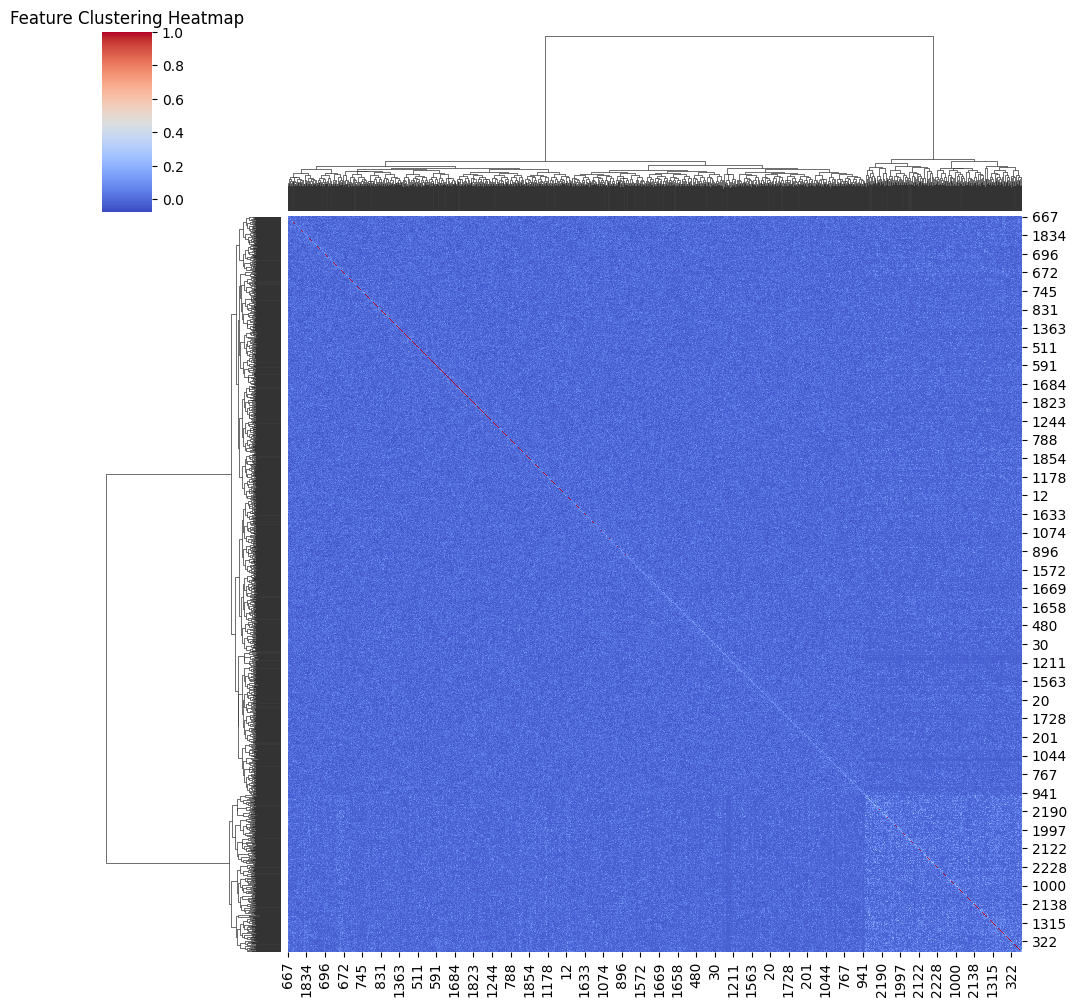

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `corr_matrix` is your correlation matrix and `cluster_labels` are assigned
sns.clustermap(
    corr_matrix, 
    metric="euclidean", 
    method="ward", 
    cmap="coolwarm", 
    figsize=(10, 10),
    row_cluster=True, 
    col_cluster=True
)
plt.title("Feature Clustering Heatmap")
plt.show()


In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
linked = linkage(corr_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=high_results.columns, orientation='right', leaf_font_size=8)
plt.title("Feature Clustering Dendrogram")
plt.show()

ValueError: Dimensions of Z and labels must be consistent.

<Figure size 1000x700 with 0 Axes>

In [ ]:
feature_names = high_inputs.iloc[samp_high_results[0]].columns
X = high_inputs.iloc[samp_high_results[0]].to_numpy()

sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', metric='euclidean', method='ward')
distances = 1 - corr_matrix
clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average')
cluster_labels = clustering.fit_predict(distances)

In [137]:
kmeans = KMeans(n_clusters=3, random_state=21)
cluster_labels = kmeans.fit_predict(pca_data)

original_data = pd.DataFrame(X, columns=feature_names)
original_data['Cluster'] = cluster_labels

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=feature_names)
print("PCA Loadings (Feature Contributions to PCs):")
print(loadings)

# Analyze original feature means by cluster
print("\nFeature Means by Cluster:")
print(original_data.groupby('Cluster').mean())

PCA Loadings (Feature Contributions to PCs):
           PC1       PC2       PC3       PC4
2     0.018517 -0.000552 -0.005853 -0.002170
4     0.015184  0.000136 -0.023232 -0.006237
5     0.017556  0.008186 -0.020537  0.011255
6     0.013526  0.015565  0.005246 -0.027834
8     0.015074  0.000787 -0.005955 -0.014284
...        ...       ...       ...       ...
8911  0.006044 -0.002998  0.005637  0.001623
8914  0.005029 -0.000487 -0.003976  0.000407
8956  0.006026 -0.005356  0.005100  0.000464
8964  0.007253 -0.011518  0.006645  0.001589
8976  0.006845 -0.012466  0.005410 -0.002746

[4499 rows x 4 columns]

Feature Means by Cluster:
             2         4         5         6         8         9         10    \
Cluster                                                                         
0        0.000000  0.016194  0.000000  0.008097  0.000000  0.008097  0.004049   
1        0.051695  0.046693  0.048916  0.044469  0.042802  0.051695  0.056698   
2        0.004016  0.000000  0.004016  

In [139]:
len(original_data)

2295

### Measure dependence of the features in the clusters

In [246]:
print(len(experiments), len(outcomes))

8998 8998


In [248]:
### print descriptive statistics of outcomes
print(df_results.describe())

                 0
count  8998.000000
mean      4.110287
std       1.742195
min       0.000000
25%       3.948825
50%       4.389533
75%       4.998629
max      10.857103


In [250]:
###print df_results that are greater than 4.4
print(df_results[df_results[0] > 4.4])

             0
2     4.791880
4     4.973522
6     4.521276
8     5.766884
9     5.371179
...        ...
8911  4.663129
8914  4.471023
8956  5.298451
8964  5.099101
8976  4.865670

[4443 rows x 1 columns]


In [253]:
### cluster df_results where the value is greater than 4.4
kmeans = KMeans(n_clusters=4, random_state=21).fit(df_results[df_results[0] > 4.4])

### print the count of each cluster
print(pd.Series(kmeans.labels_).value_counts())




0    2127
1    1459
3     707
2     150
Name: count, dtype: int64


In [256]:
### print the results for cluster 3
df_cluster = df_results[df_results[0] > 4.4]
print(df_cluster[kmeans.labels_ == 3])



             0
8     5.766884
19    6.004234
30    5.912854
36    5.889632
38    6.288743
...        ...
8403  6.983640
8406  5.662526
8453  5.767372
8472  5.873842
8484  6.430343

[707 rows x 1 columns]


In [257]:
### get the index values of df_cluster[kmeans.labels_ == 3]
idx = df_cluster[kmeans.labels_ == 3].index

### get the rows of experiments based on idx
print(experiments.iloc[idx])

      333615  332041  343220  328559  329741  329385  334269  332584  344418  \
8          0       0       1       0       0       0       0       0       0   
19         0       0       0       0       0       0       0       0       0   
30         0       0       0       0       0       0       0       0       0   
36         0       0       0       0       0       0       0       0       0   
38         0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
8403       0       0       0       0       0       0       0       0       0   
8406       0       0       0       0       0       1       0       0       0   
8453       0       0       0       1       0       0       0       0       0   
8472       0       0       0       0       0       0       0       0       0   
8484       0       0       0       0       0       0       0       0       0   

      331224  ...  330399  331209  3281

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

mi_matrix = np.zeros(((len(df.columns), len(df.columns))))
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        mi_matrix[i, j] = mutual_info_regression(df.iloc[:, i].values.reshape(-1, 1), df.iloc[:, j].values)

mi_matrix

/tmp/ipykernel_32516/1305173201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mutual_info_regression(df.iloc[:, i].values.reshape(-1, 1), df.iloc[:, j].values)
/tmp/ipykernel_32516/1305173201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mutual_info_regression(df.iloc[:, i].values.reshape(-1, 1), df.iloc[:, j].values)
/tmp/ipykernel_32516/1305173201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] =

In [265]:
print(len(mi_scores))
mi_scores[2]


2295


0.007805543111264024

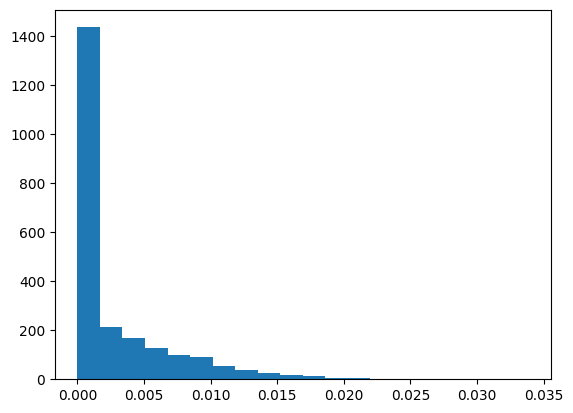

In [261]:
### Print histogram of mi_scores
plt.hist(mi_scores, bins=20)
plt.show()